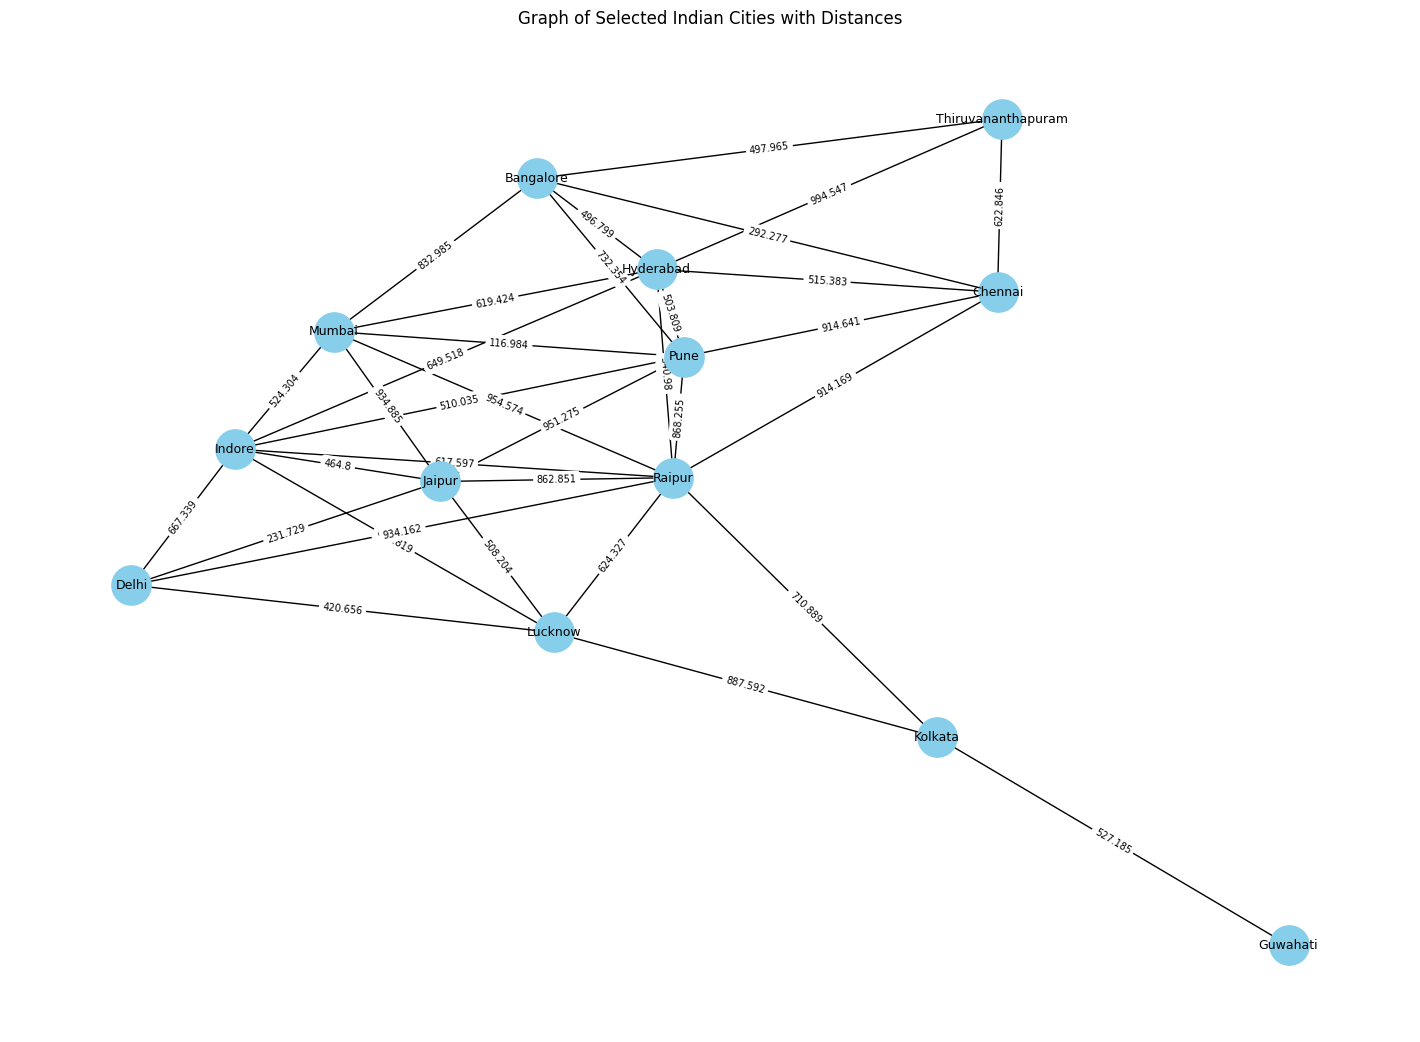

In [28]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("Distances.csv", index_col=0)

# Clean city names in index and columns (strip extra spaces)
df.index = df.index.str.strip()
df.columns = df.columns.str.strip()

# Replace 100000.0 with None to indicate no connection
df.replace(100000.0, None, inplace=True)

# Define list of specific cities
selected_cities = [
    "Bangalore", "Hyderabad","Delhi", "Thiruvananthapuram",
    "Lucknow", "Chennai", "Mumbai", "Pune",
    "Kolkata", "Jaipur",  "Indore","Guwahati","Raipur"
]

# Filter only those cities that are present in the data
existing_cities = [city for city in selected_cities if city in df.index]

# Filter the DataFrame for selected cities
subgraph_df = df.loc[existing_cities, existing_cities]

# Create graph
G = nx.Graph()

# Add edges
for i, source in enumerate(subgraph_df.index):
    for j, target in enumerate(subgraph_df.columns):
        distance = subgraph_df.iloc[i, j]
        if pd.notna(distance) and distance != 0:
            G.add_edge(source, target, weight=distance)

# Plot the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=9)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Graph of Selected Indian Cities with Distances")
plt.show()


In [11]:
from tkinter import *
import folium
import pandas as pd
import os


def getGraphPoints():
	#reading distances matrix
	data_dist = pd.read_csv('Distances.csv')
	gp = data_dist.to_dict()

	cities = []
	city_list = pd.read_csv('Lat_Long.csv')

	for i in city_list['City']:
		cities.append(i)

	gp.pop('Unnamed: 0')
	graph = {}
	for key in gp:
		tem = {}
		for j in gp[key]:
			tem[cities[j]] = gp[key][j]
		graph[key] = tem

	data_lat_long = pd.read_csv('Lat_Long.csv')
	dict_data_lat= data_lat_long.to_dict()
	points = {}
	for i in range(len(cities)):
		points[ dict_data_lat['City'][i] ] = ( dict_data_lat['Latitude'][i], dict_data_lat['Longitude'][i] )
	return(graph,points)




In [12]:
from tkinter import *
import folium
import pandas as pd
import os


def dijkstra(graph,inf_value, src, dest):
    '''
    This function returns minimum distance between src and dest along with 'path' dictionary
    return value = int,dictionary
    graph : it is the dictionary
    inf_value : it is the infinity value for particular graph
    src : source vertex of the graph
    dest : destination vertex of the graph
    '''

    #initialization of data structures
    graph,points = getGraphPoints()
    nodes = len(graph)
    visited  = {}
    distance = {}
    path = {}
    path[src] = '-1'  #taking this value for to stop looking for path at source

    #calculating cities dynamically
    cities = []
    city_list = pd.read_csv('Lat_Long.csv')

    for i in city_list['City']:
        cities.append(i)

    print(cities)

    for i in cities:
        if i == src:
            distance[src] = 0
        else:
            distance[i] = 99999999999
        visited[i] = False
#     print(distance)
#     print(visited)

    #traversing the nodes n-1 times
    i = 0
    while i < (nodes-1):

        #code for finding mini distance non visited node
        min_key = mini_not_visited(distance, visited)
#         print(min_key)

        #marking the visited node
        visited[min_key] = True

        for neigh_city,val in graph[min_key].items():
            val = int(val)
            if val != inf_value and visited[neigh_city] == False:
                #relaxation
                newDist = distance[min_key] + val
                if newDist < distance[neigh_city]:
                    distance[neigh_city] = newDist
                    #setting path also
                    path[neigh_city] = min_key
        #increment
        i+=1

    return distance[dest],path

def mini_not_visited(distance, visited):
    mini = 999999999999
    min_key = ''
    for key,val in distance.items():
        if val < mini and visited[key] == False:
            min_key = key
            mini = val
    return min_key

In [23]:
from tkinter import *
import folium
import pandas as pd
import os
from flask import Flask, render_template, url_for,request



src = input("Enter src :")
dest = input("Enter dest :")
graph,points = getGraphPoints()
min_dist,path = dijkstra(graph, 100000, src, dest)

print("Shortest distance=",min_dist)
print("Path to choose",path)

val = dest
pts = [(points[dest][0], points[dest][1])]
while path[val] != '-1':
    city = path[val]
    pts.append( (points[city][0], points[city][1]) )
    val = city

print(pts)

m = folium.Map(location=[20.5937, 78.9629], zoom_start=6)

# #points marking
# for key,[lat,long] in points.items():
#     folium.Marker([lat,long], popup=key ).add_to(m)

# folium.PolyLine(pts).add_to(m)


Enter src :Delhi
Enter dest :Pune
['Guwahati', 'Kolkata', 'Raipur', 'Thiruvananthapuram', 'Jaipur', 'Chennai', 'Hyderabad', 'Pune', 'Indore', 'Delhi', 'Bangalore', 'Lucknow', 'Mumbai']
Shortest distance= 1177
Path to choose {'Delhi': '-1', 'Raipur': 'Delhi', 'Jaipur': 'Delhi', 'Indore': 'Delhi', 'Lucknow': 'Delhi', 'Pune': 'Indore', 'Mumbai': 'Jaipur', 'Kolkata': 'Lucknow', 'Hyderabad': 'Indore', 'Chennai': 'Hyderabad', 'Bangalore': 'Hyderabad', 'Guwahati': 'Kolkata', 'Thiruvananthapuram': 'Bangalore'}
[(18.521428, 73.8544541), (22.7203616, 75.8681996), (28.6273928, 77.1716954)]
